# <div id="chap1">1. Import libraries

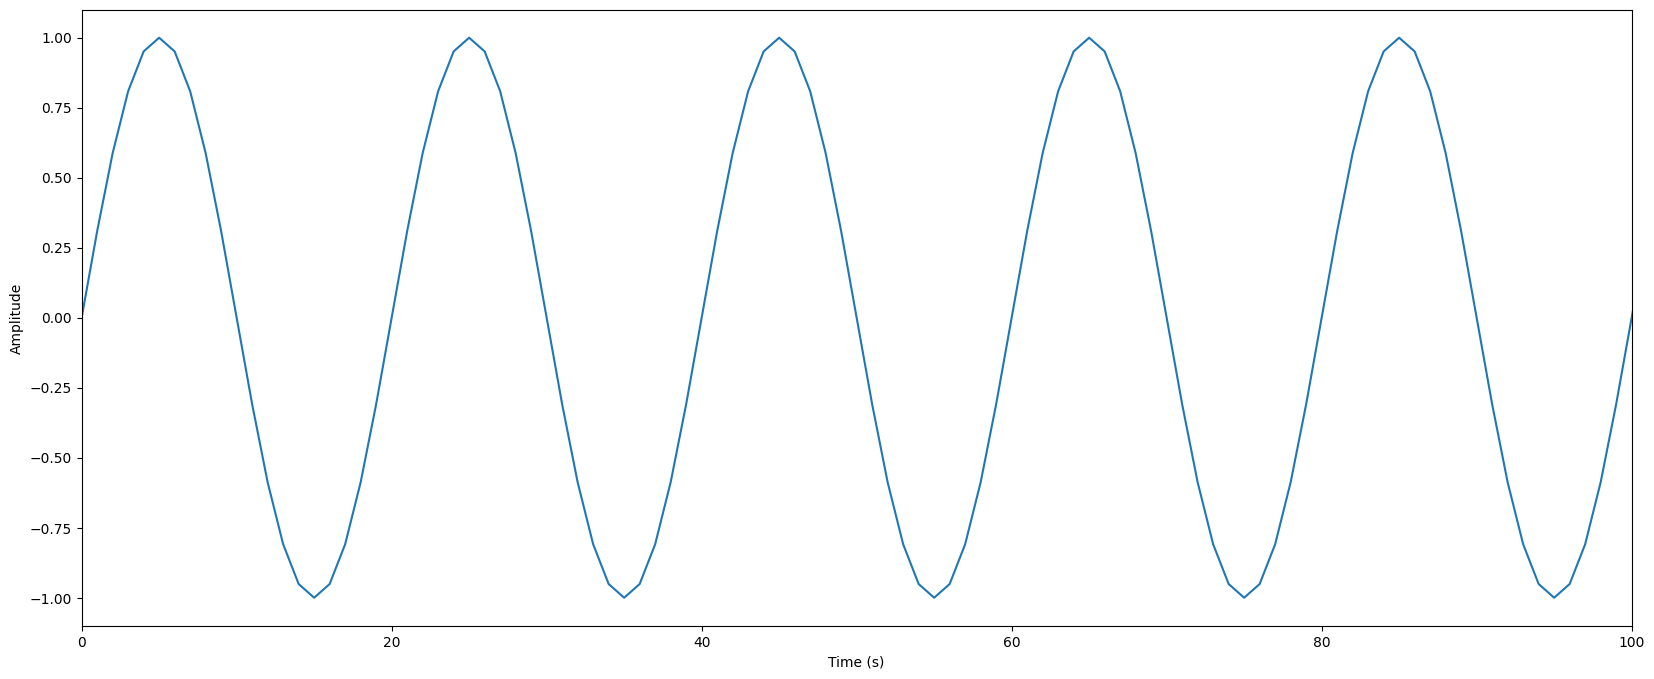

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 設定波形參數
amplitude = 1  # 振幅
frequency = 0.05  # 頻率
phase = 0      # 相位
duration = 6000   # 時間長度，單位為秒
sampling_rate = 1  # 取樣率，單位為 Hz

# 計算波形數據
time = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
waveform = amplitude * np.sin(2 * np.pi * frequency * time + phase)

# 繪製波形圖
plt.figure(figsize=(20, 8))
plt.plot(waveform)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0,100)
plt.show()

In [2]:
len(waveform)

6000

In [3]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
# import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.random import shuffle

In [4]:
import yfinance as yf

# <div id="chap2">2. Preprocessing

In [5]:
stock_name = "^GSPC"
date_predict_start = '2019-01-01'
data_range = 250
slide_range = 10
n_slide = 10
pv_range = 2
# n_harm_lower_limit = 1
# n_harm_upper_limit = 50
# fit_method = 'rmse'
# pv_method = 'CL'

In [6]:
COMPANY = '^GSPC'

In [7]:
data = yf.download(COMPANY, start='1999-01-01', end='2019-06-30')
len(data)

[*********************100%***********************]  1 of 1 completed


5155

In [8]:
data['Close'] = waveform[:len(data)]

In [9]:
array_data = np.array(data['Close'])
n_data = array_data.size
time_data = np.arange(0, n_data)
Polynomial = np.polyfit(time_data, array_data, 1)
data_notrend = array_data - Polynomial[0] * time_data  # detrended x
data['Close'] = data_notrend

In [10]:
train_data = data.loc[data.index < date_predict_start]
print(len(train_data))
test_data = data.loc[data.index > date_predict_start]
print(len(test_data))

5031
124


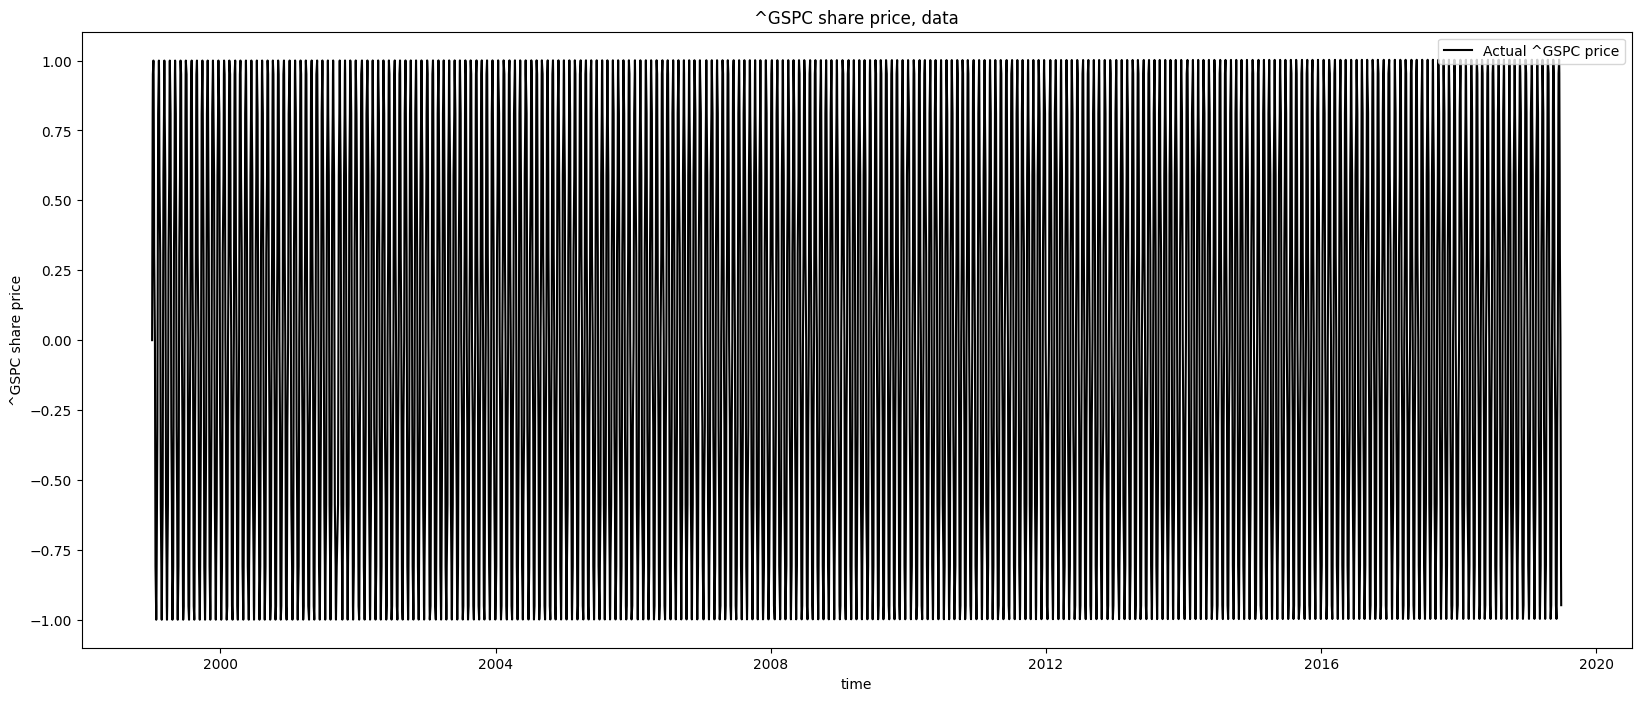

In [11]:
plt.figure(figsize=(20, 8))
plt.plot(data['Close'], 'black', label=f"Actual {COMPANY} price")
plt.title(f"{COMPANY} share price, data")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

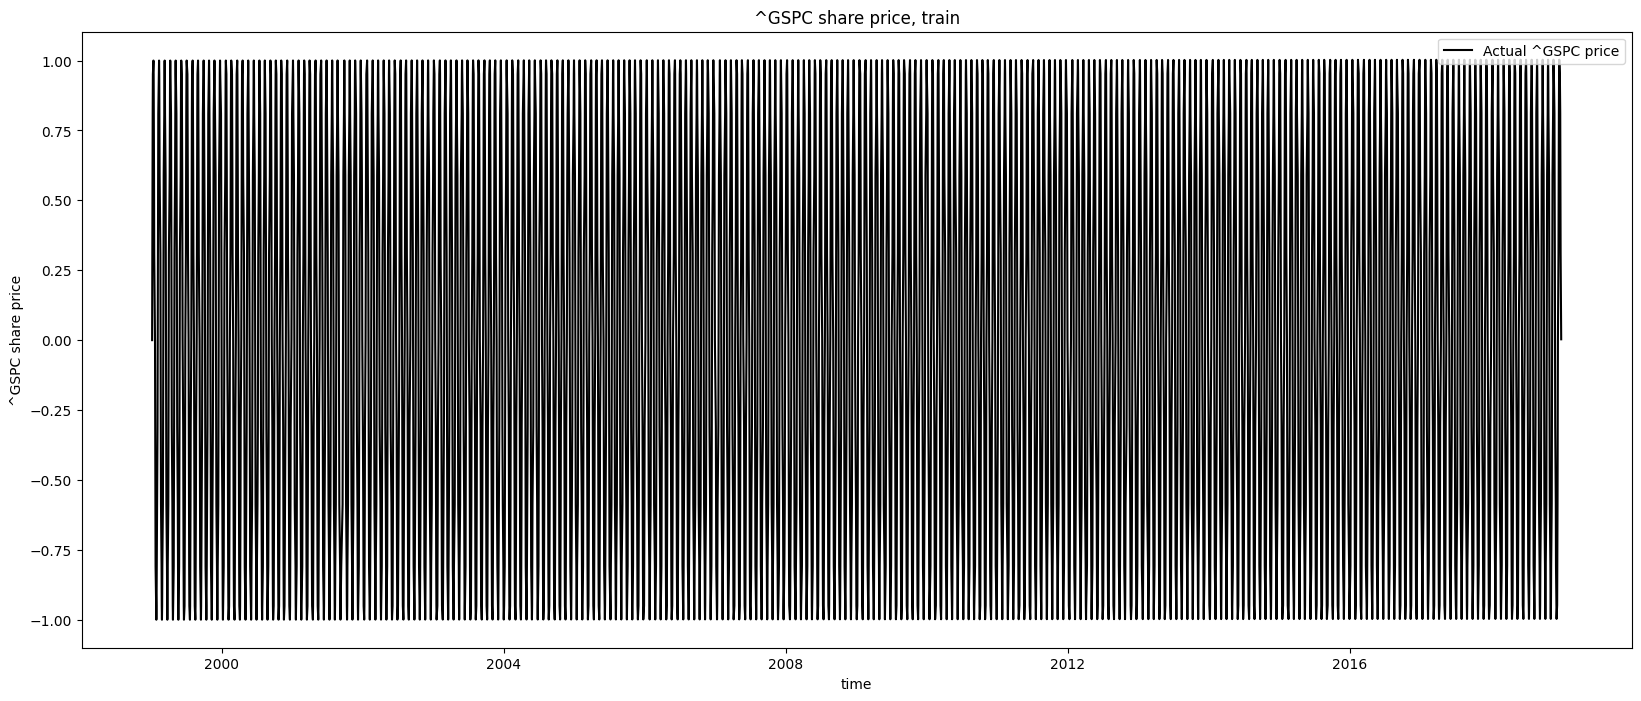

In [12]:
plt.figure(figsize=(20, 8))
plt.plot(train_data['Close'], 'black', label=f"Actual {COMPANY} price")
plt.title(f"{COMPANY} share price, train")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

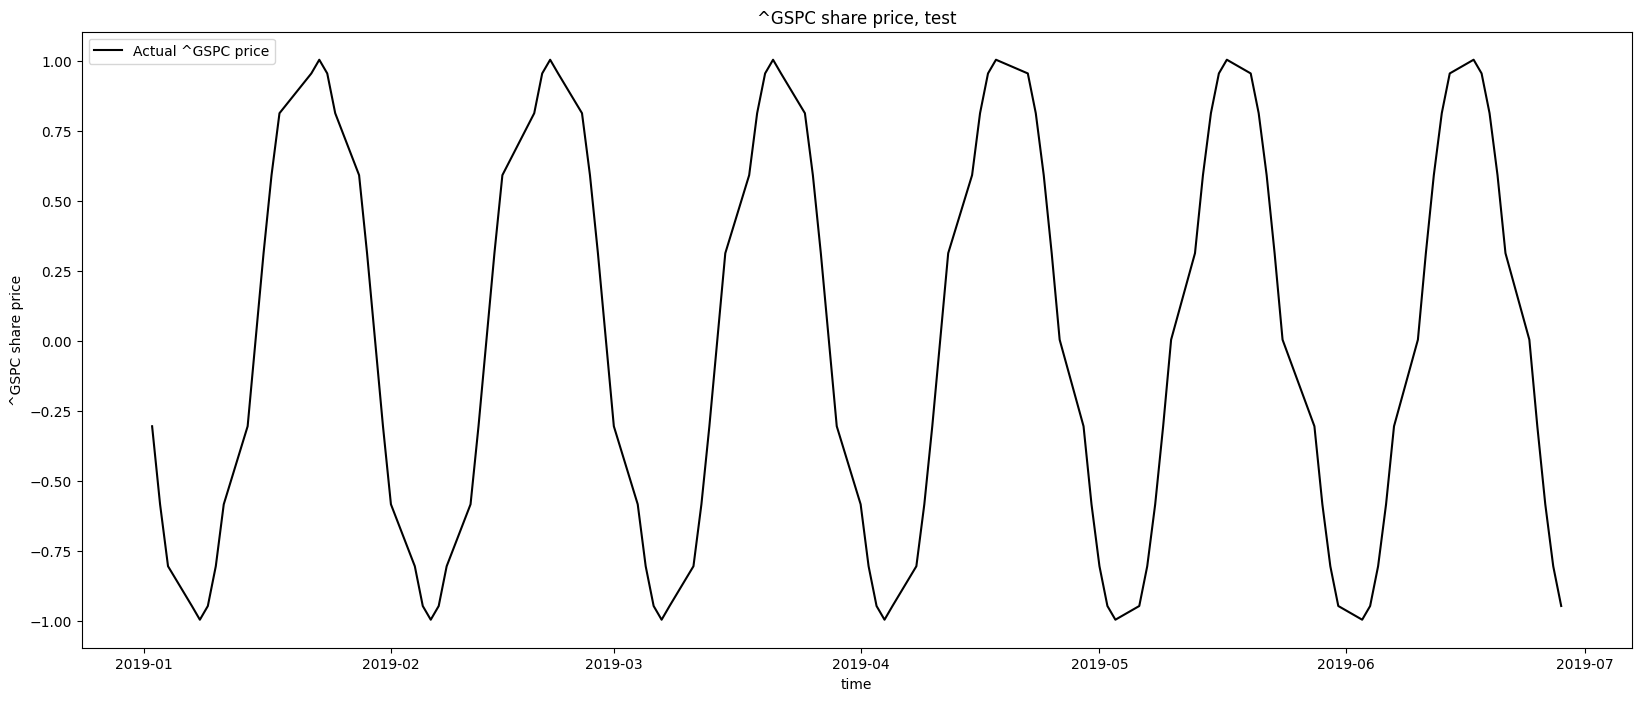

In [13]:
plt.figure(figsize=(20, 8))
plt.plot(test_data['Close'], 'black', label=f"Actual {COMPANY} price")
plt.title(f"{COMPANY} share price, test")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

In [14]:
# Normalize data
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))

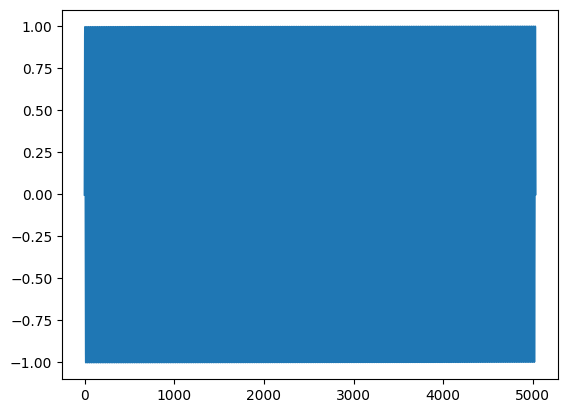

In [15]:
plt.plot(scaled_data)

In [16]:
# how many days do i want to base my predictions on ?
base_day = 250
prediction_day = 30
x_train = []
y_train = []
slide = 10
# 從base_day開始，往前提取base_day天的數據，作為輸入變量x_train，並將當前價格作為輸出變量y_train
for x in range(base_day+prediction_day, len(scaled_data), slide):
    x_train.append(scaled_data[x-base_day-prediction_day:x-prediction_day, 0])
    y_train.append(scaled_data[x-prediction_day:x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

# # 將x_train數組的形狀轉換為（樣本數，天數，特徵數）的形式，這裡的特徵數為1
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

In [17]:
x_train.shape

(476, 250, 1)

In [18]:
y_train.shape

(476, 30, 1)

# <div id="chap3">3. Build LSTM model

In [19]:
def LSTM_model(prediction_day):
    
    model = Sequential()
    
    model.add(LSTM(units = 256, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.4))

    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.4))

    model.add(LSTM(units = 64))
    model.add(Dropout(0.4))
    
    model.add(Dense(units=prediction_day))
    
    return model

# <div id="chap4">4. Training

In [20]:
# model = LSTM_model()
# model.summary()
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Define callbacks
# # Save weights only for best model
# checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', verbose = 2, save_best_only = True)
# earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)

# history = model.fit(x_train, y_train, epochs=25, batch_size = 32, callbacks = [checkpointer, earlystopper], validation_split = 0.2)

# # plot loss curves
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='validation')
# plt.legend()
# plt.show()


In [21]:
model = LSTM_model(prediction_day)
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250, 256)          264192    
                                                                 
 dropout (Dropout)           (None, 250, 256)          0         
                                                                 
 lstm_1 (LSTM)               (None, 250, 128)          197120    
                                                                 
 dropout_1 (Dropout)         (None, 250, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 30)                1

In [22]:
# # Define callbacks

# # Save weights only for best model
# checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
#                                verbose = 2, 
#                                save_best_only = True)

# model.fit(x_train, 
#           y_train, 
#           epochs=25, 
#           batch_size = 32,
#           callbacks = [checkpointer])

In [23]:
# Define callbacks
# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', verbose = 2, save_best_only = True)
earlystopper = EarlyStopping(monitor = 'val_loss', patience = 90, verbose = 2)
history = model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks = [checkpointer, earlystopper], validation_split = 0.2, shuffle=True)


Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.3579
Epoch 1: val_loss improved from inf to 0.07612, saving model to weights_best.hdf5
12/12 [==============================] - 25s 2s/step - loss: 0.3579 - val_loss: 0.0761
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.1341
Epoch 2: val_loss improved from 0.07612 to 0.00919, saving model to weights_best.hdf5
12/12 [==============================] - 19s 2s/step - loss: 0.1341 - val_loss: 0.0092
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.0888
Epoch 3: val_loss improved from 0.00919 to 0.00497, saving model to weights_best.hdf5
12/12 [==============================] - 20s 2s/step - loss: 0.0888 - val_loss: 0.0050
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 0.0686
Epoch 4: val_loss improved from 0.00497 to 0.00292, saving model to weights_best.hdf5
12/12 [==============================] - 26s 2s/step - loss: 0.0686 - val_loss: 0.0029
Epoch 5/

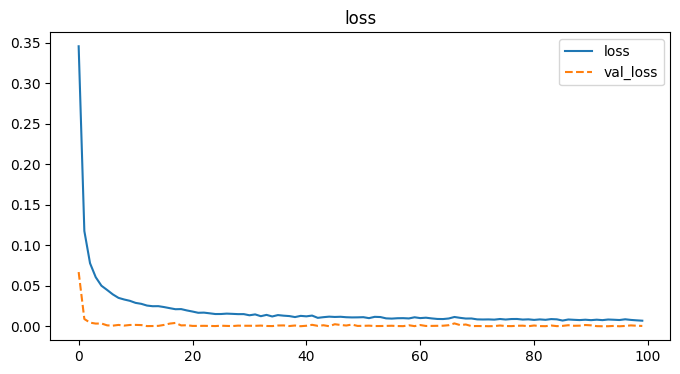

In [ ]:
# Loss
fig, ax = plt.subplots(figsize=(8,4))
plt.title('loss')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss', linestyle='--')
plt.legend()
plt.show()



# <div id="chap5">5. Predictions

In [ ]:
# test model accuracy on existing data

actual_prices = test_data['Close'].values
total_dataset = pd.concat((train_data['Close'], test_data['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset)-len(test_data)-base_day:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

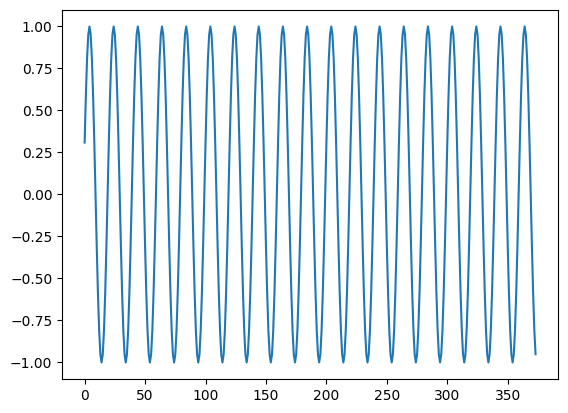

In [ ]:
plt.plot(model_inputs)

In [ ]:
x_test = []
y_test = []
for x in range(base_day+prediction_day, len(model_inputs), slide):
    x_test.append(model_inputs[x-base_day-prediction_day:x-prediction_day, 0])
    y_test.append(model_inputs[x-prediction_day:x, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = model.predict(x_test)
# predicted_prices = scaler.inverse_transform(predicted_prices)
print(f"predicted_prices: {predicted_prices}")

1/1 [==============================] - 1s 1s/step
predicted_prices: [[ 5.5222190e-04 -2.9643199e-01 -5.6839180e-01 -8.0151510e-01
  -9.4556415e-01 -9.6247452e-01 -9.4214755e-01 -7.9762483e-01
  -5.7564527e-01 -2.9895604e-01  5.0477469e-03  2.9732448e-01
   5.7753742e-01  7.9443049e-01  9.2976075e-01  9.9561834e-01
   9.1839284e-01  8.0853844e-01  5.8665574e-01  3.0016312e-01
  -5.5766449e-04 -3.1162024e-01 -5.7207149e-01 -8.3645558e-01
  -9.3031818e-01 -9.7905153e-01 -9.1703469e-01 -7.7008682e-01
  -5.8477026e-01 -2.9413381e-01]
 [ 5.1129349e-03  3.0675235e-01  5.7525343e-01  8.1641752e-01
   9.5406115e-01  9.6121293e-01  9.4893682e-01  8.0869573e-01
   5.9055012e-01  2.9710588e-01  2.7314082e-03 -3.0108026e-01
  -5.8295029e-01 -8.0581015e-01 -9.5059562e-01 -9.9493533e-01
  -9.3347359e-01 -8.2183135e-01 -5.9154379e-01 -3.1276080e-01
  -1.7371522e-03  3.1435537e-01  5.7638460e-01  8.3102983e-01
   9.4201821e-01  9.9893093e-01  9.4533366e-01  7.8982997e-01
   6.1078876e-01  3.0495402e-01

In [ ]:
type(predicted_prices)

numpy.ndarray

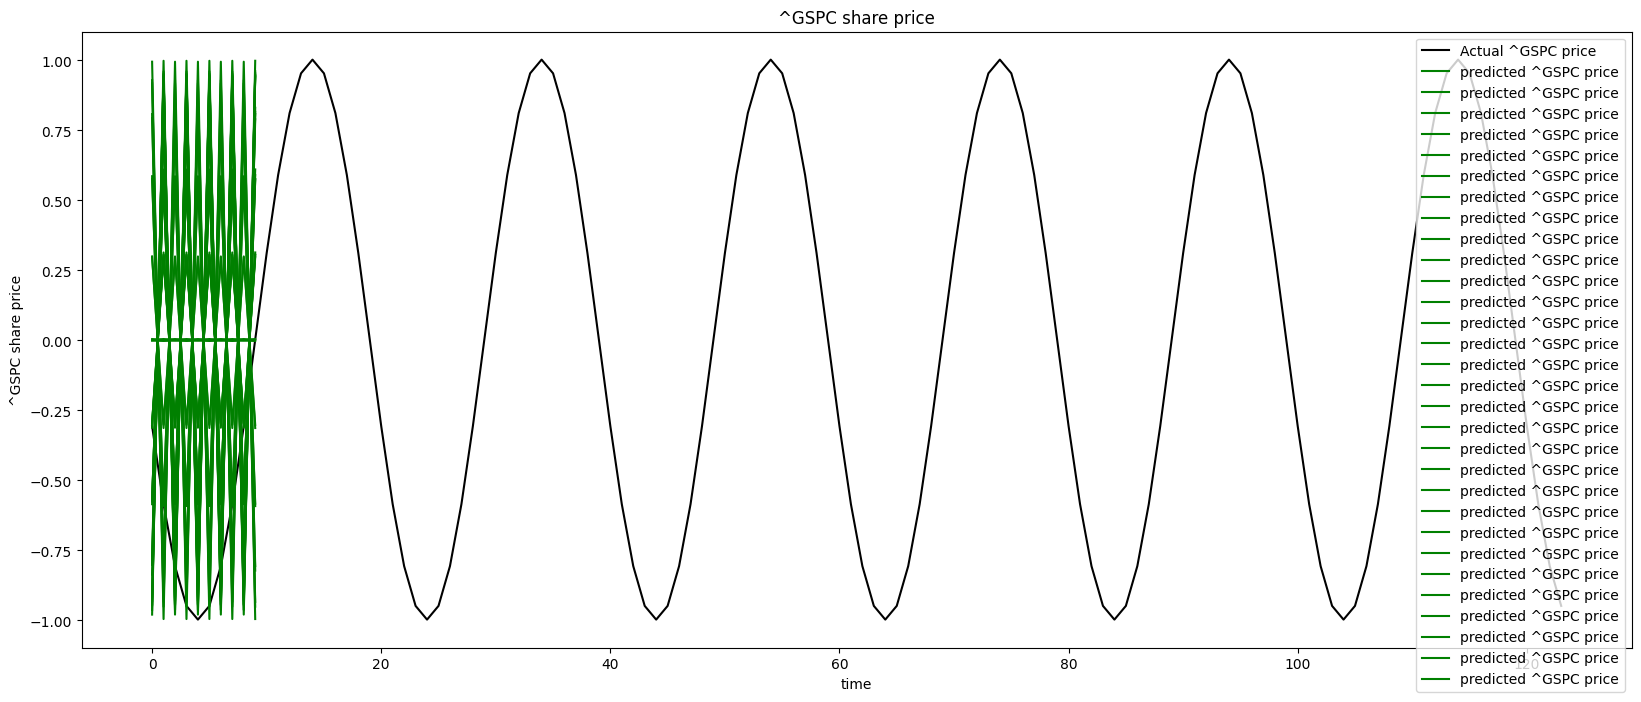

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")
plt.plot(predicted_prices, color='green', label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

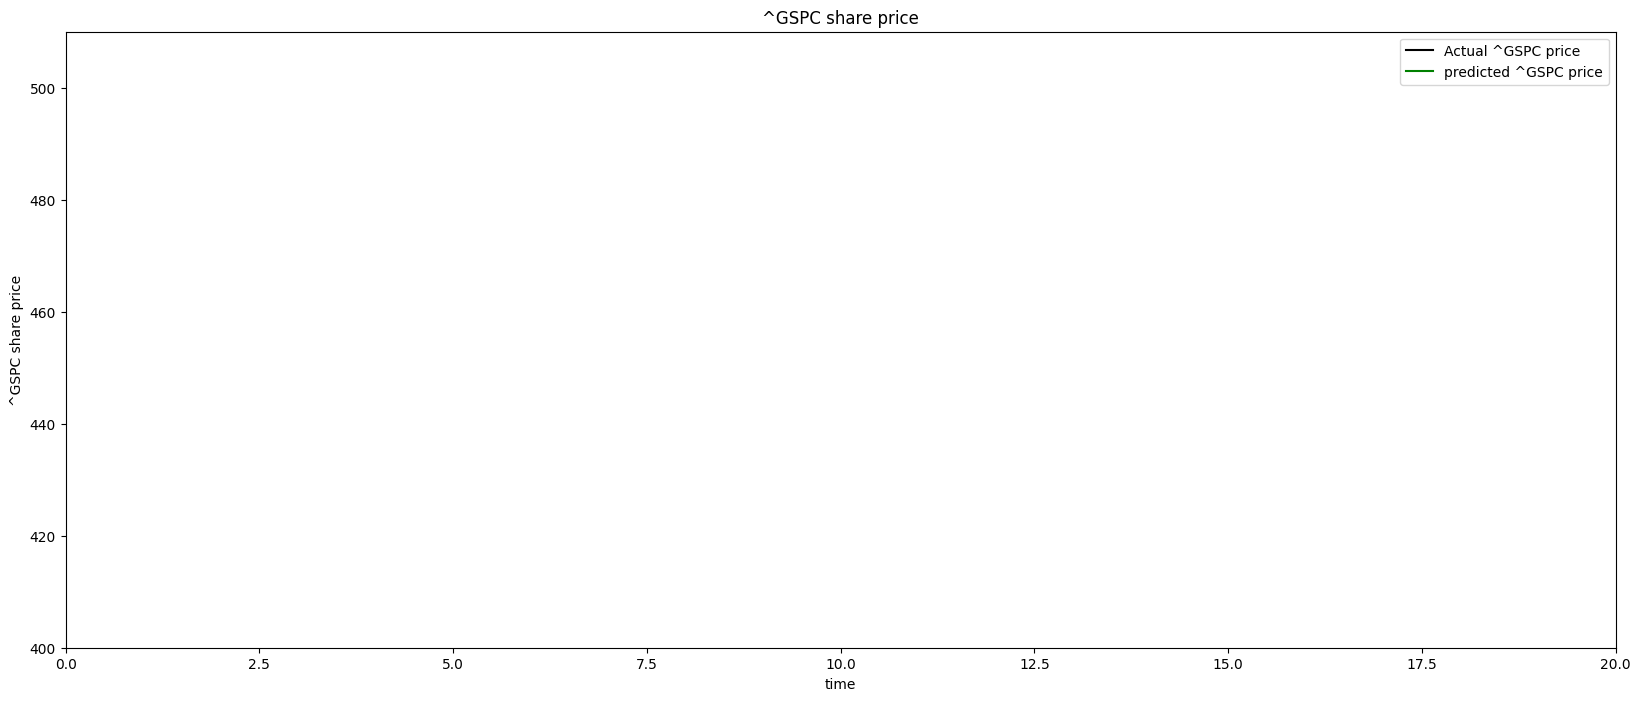

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")
plt.plot(predicted_prices[0], color= 'green', label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.xlim(0, 20)
plt.ylim(400, 510)
plt.legend()
plt.show()

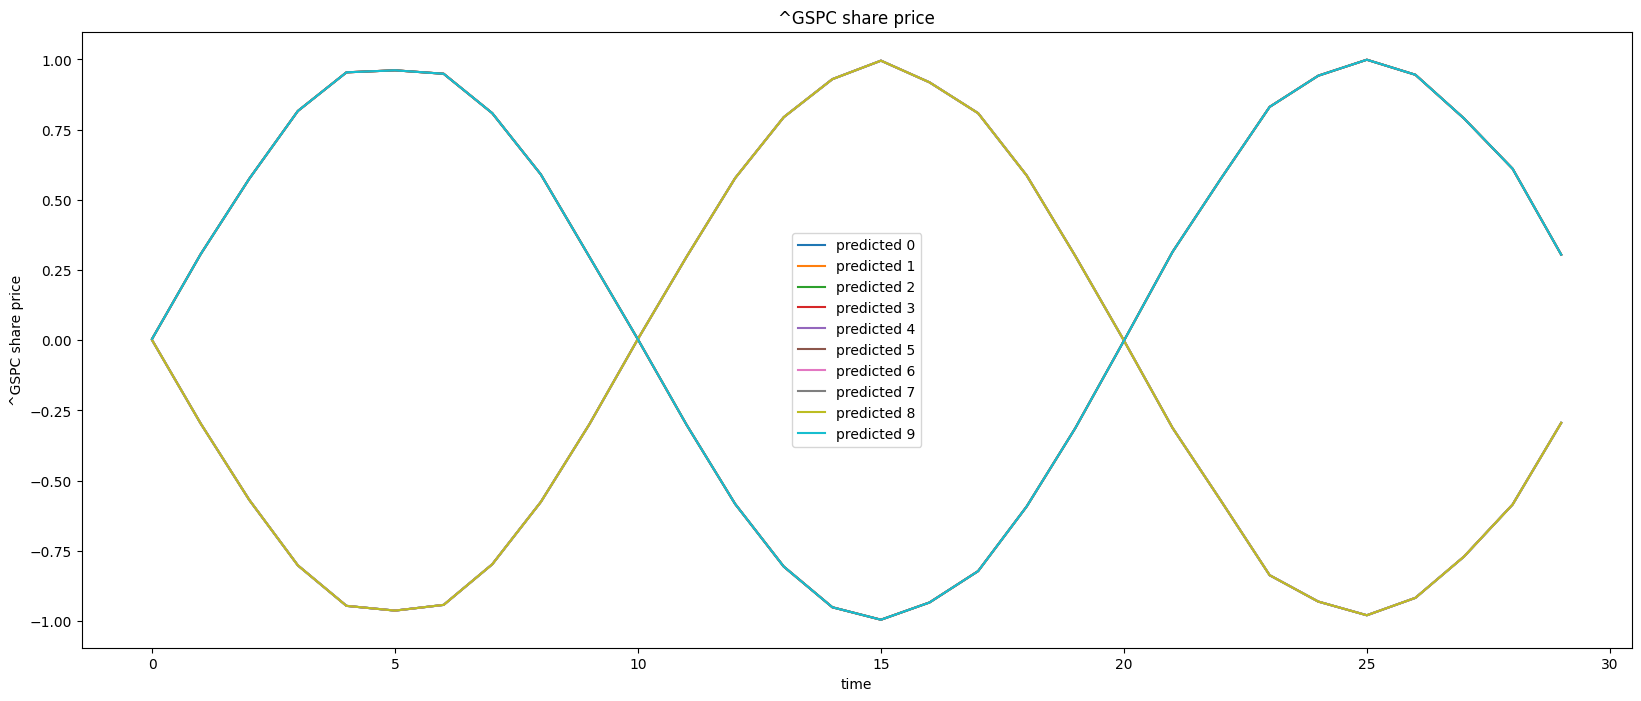

In [ ]:
plt.figure(figsize=(20, 8))
for i in range(0, 10):
    plt.plot(predicted_prices[i], label=f"predicted {i}")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
# plt.xlim(0, 9)
# plt.ylim(400, 510)
plt.legend()
plt.show()

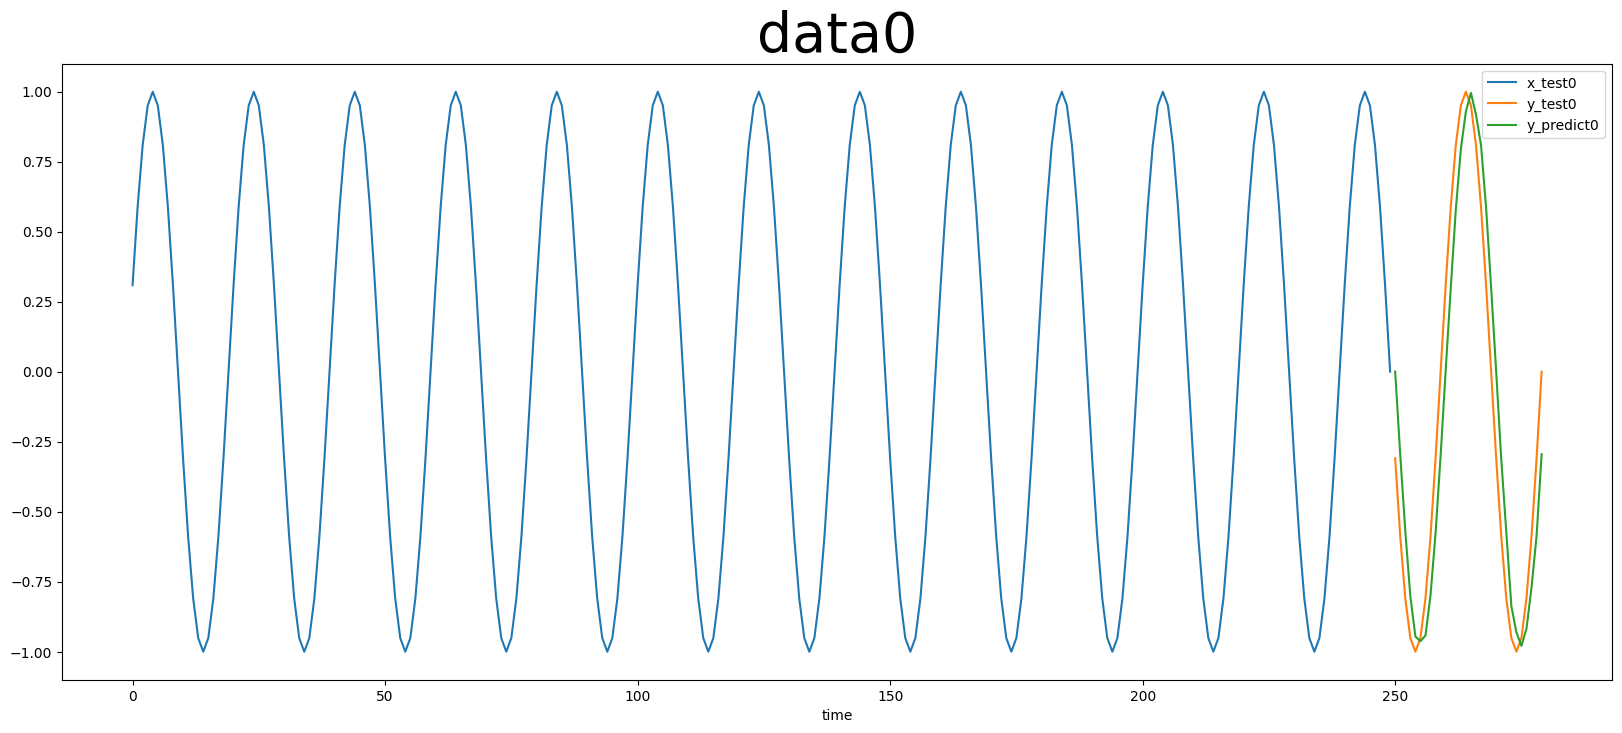

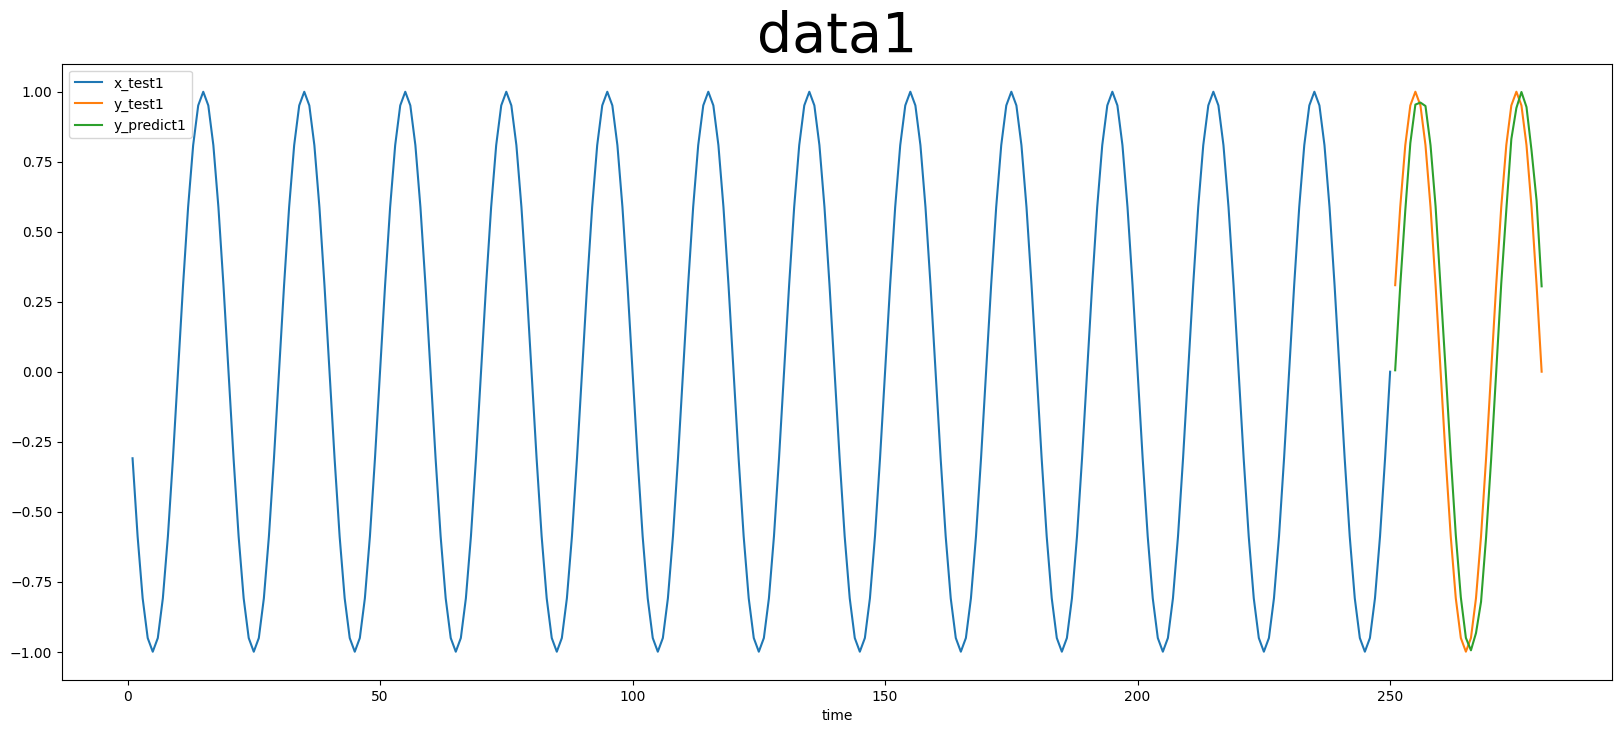

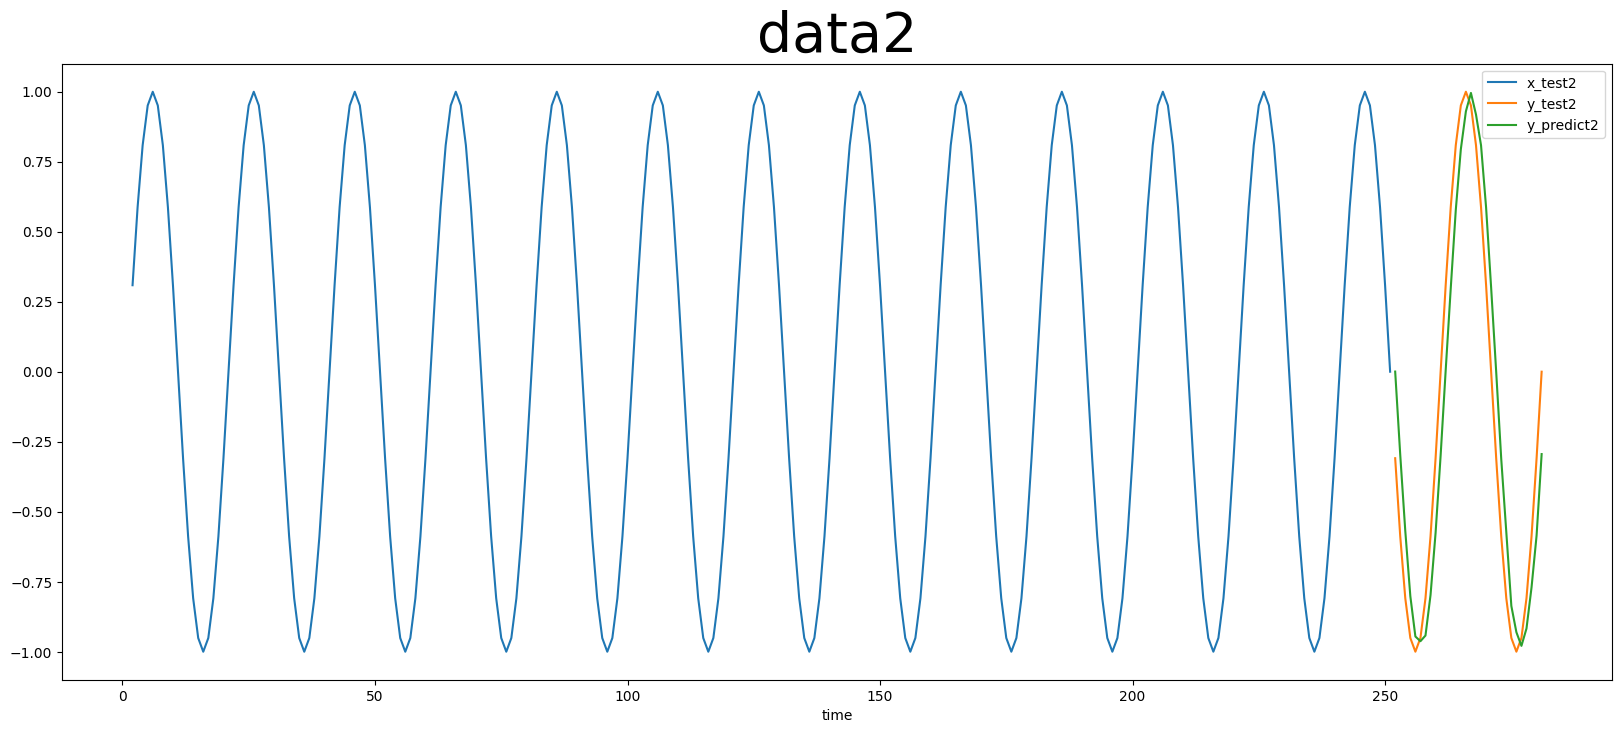

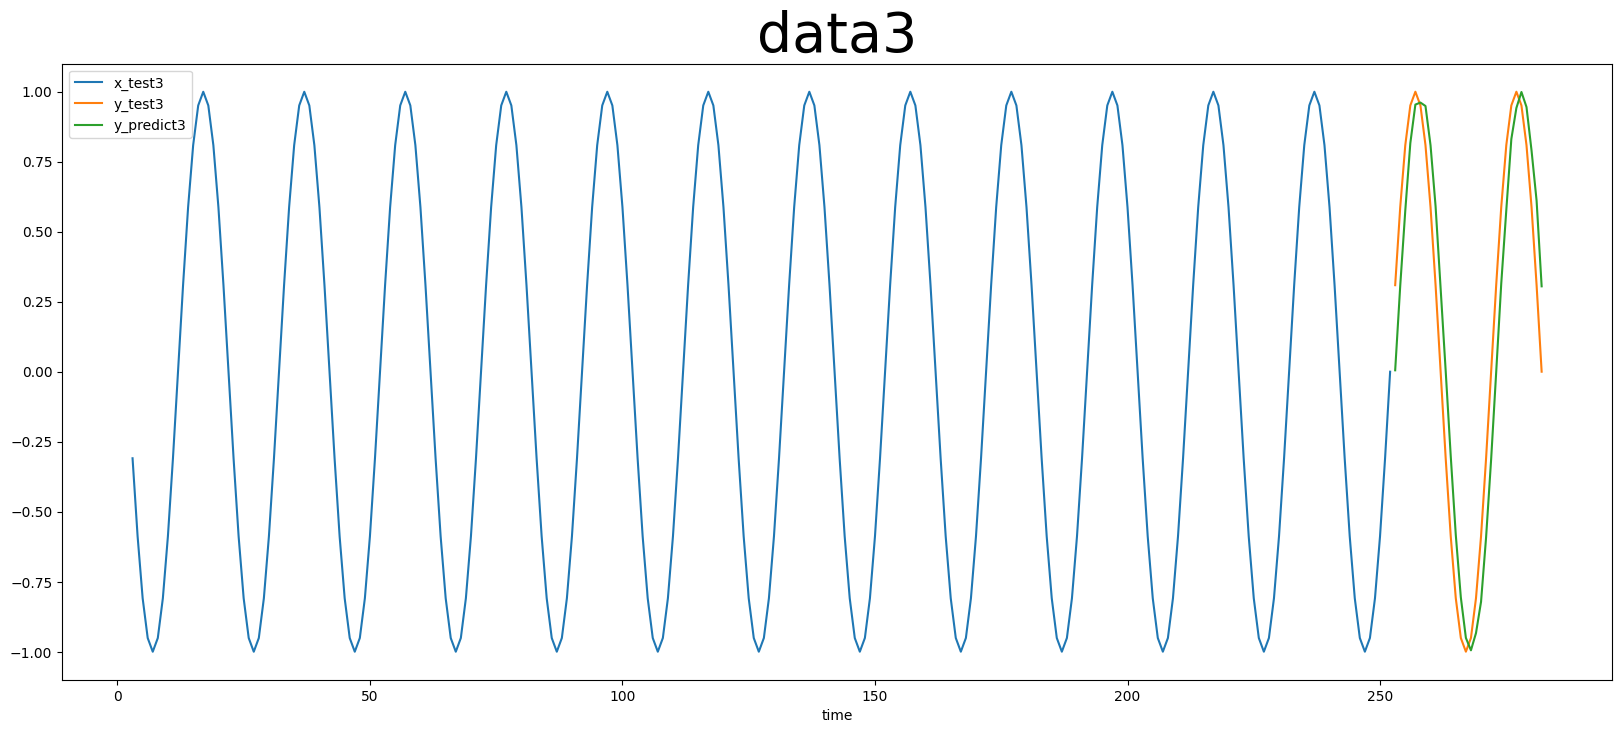

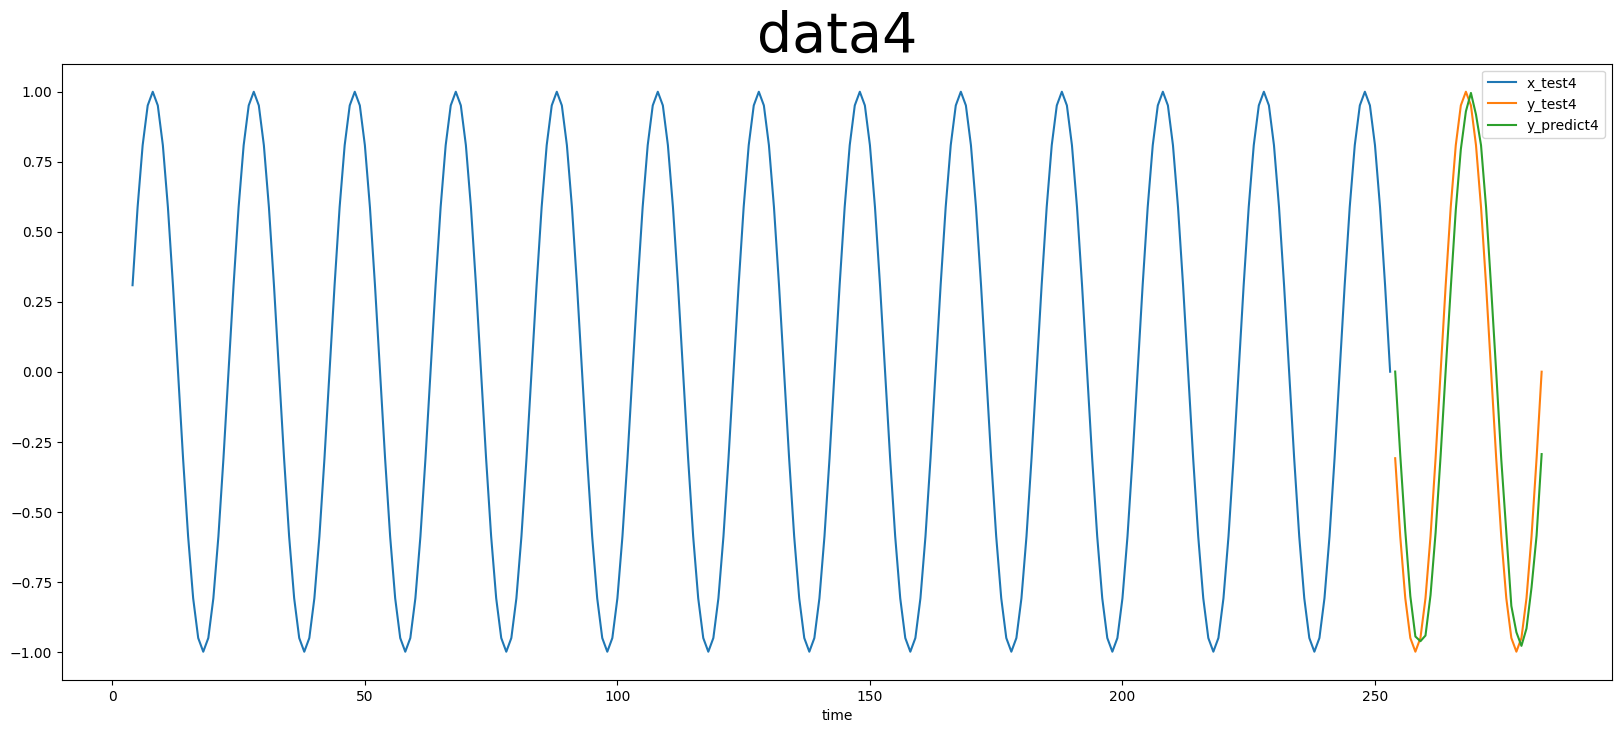

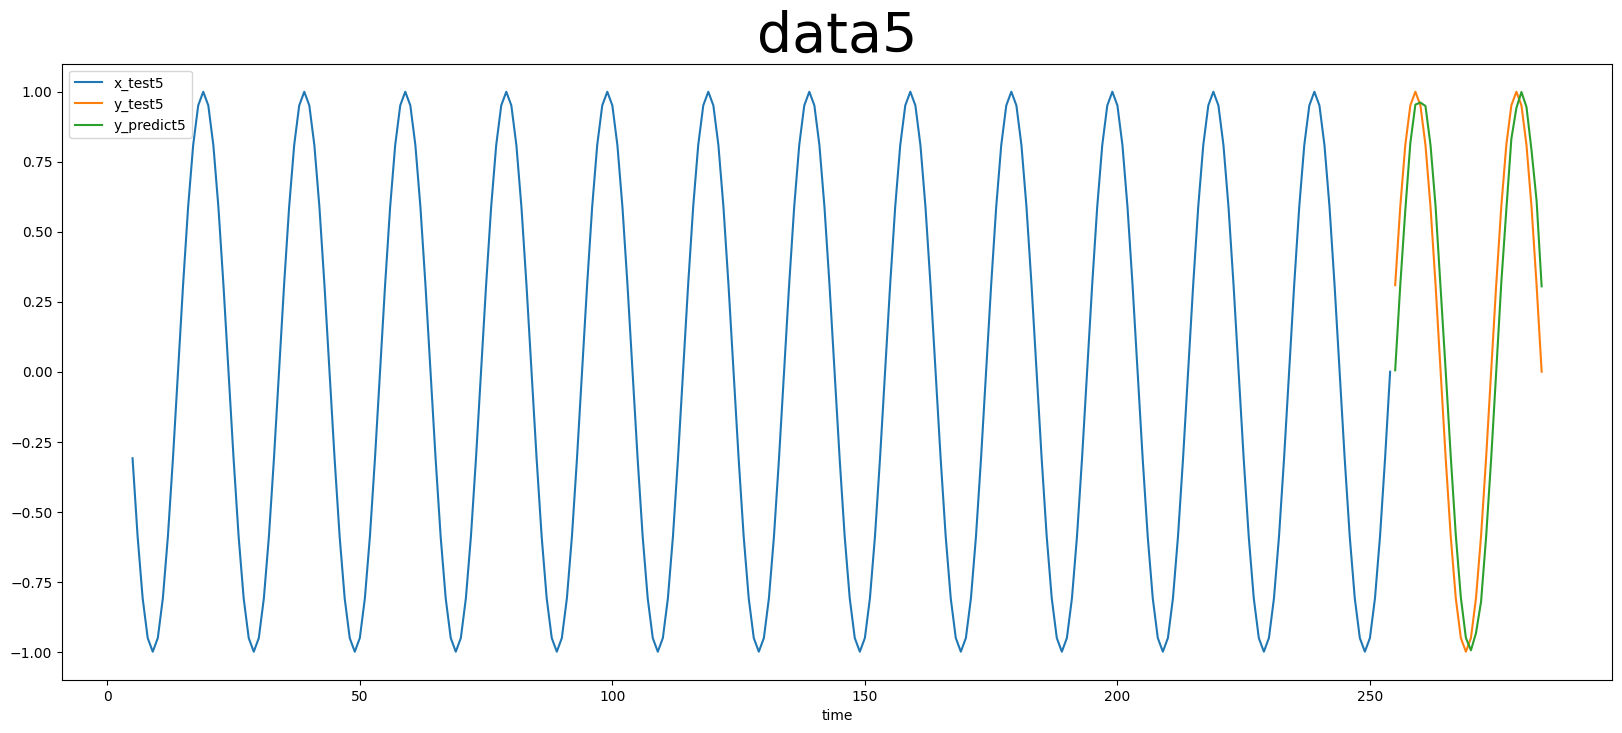

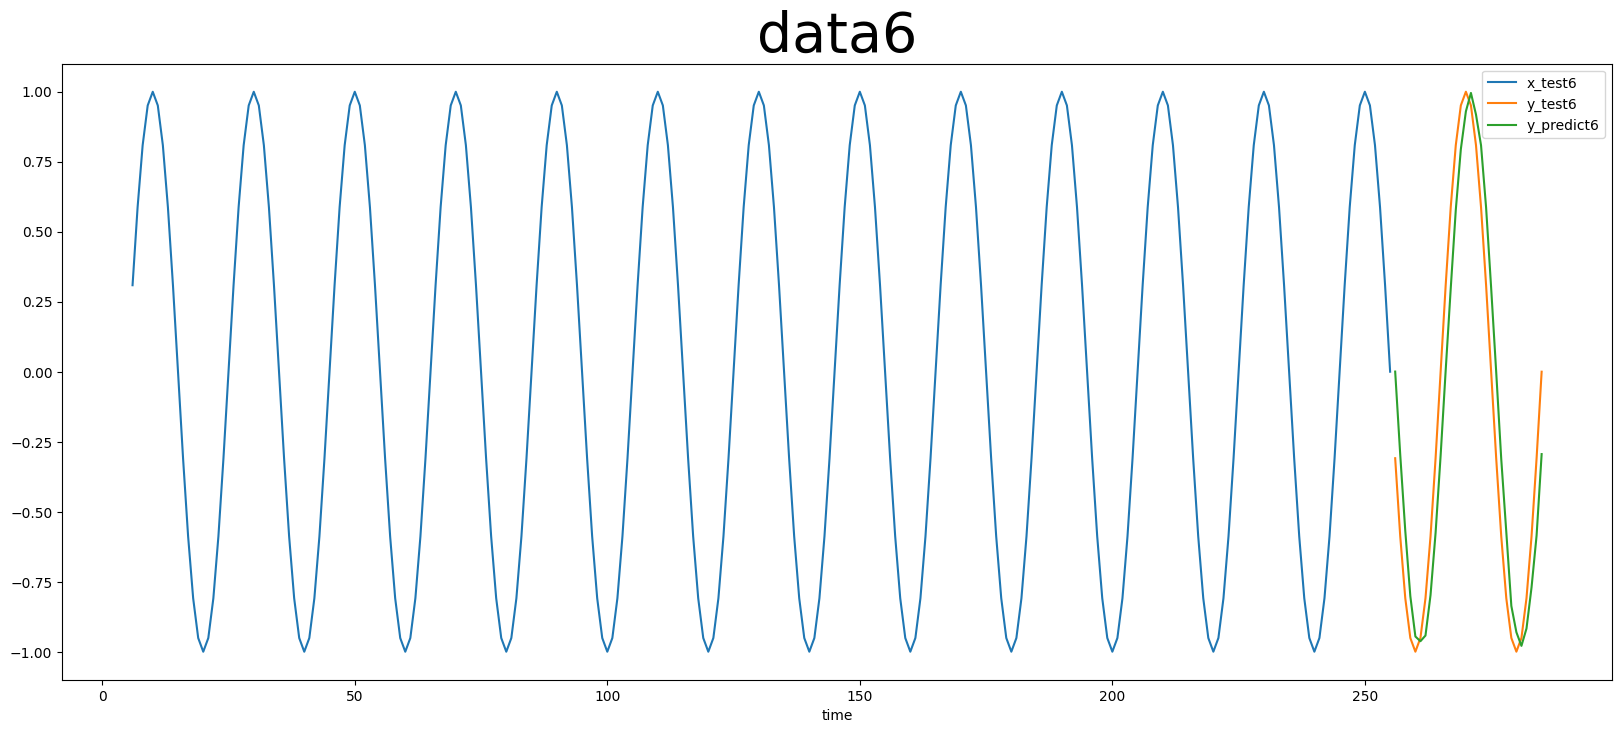

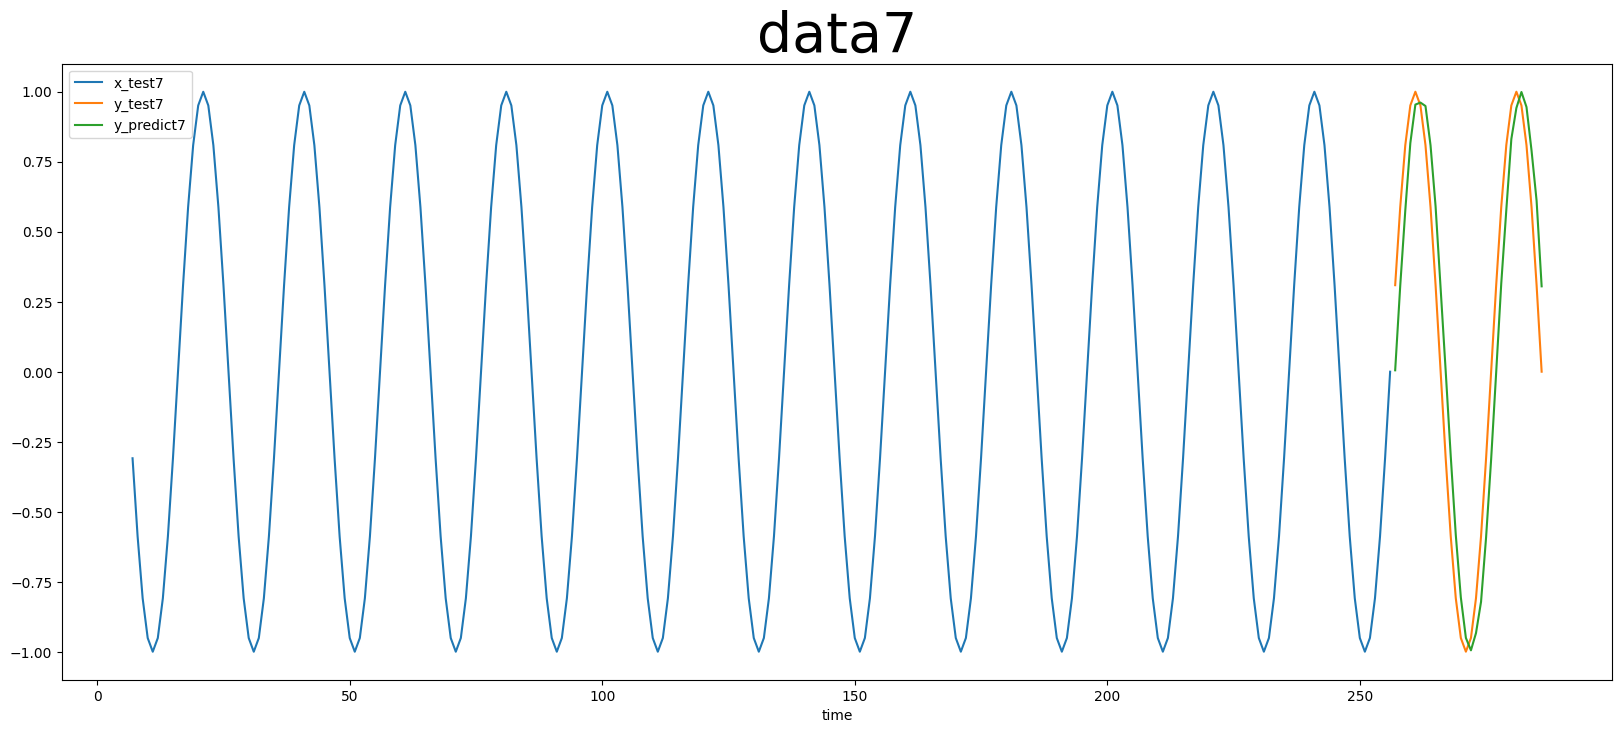

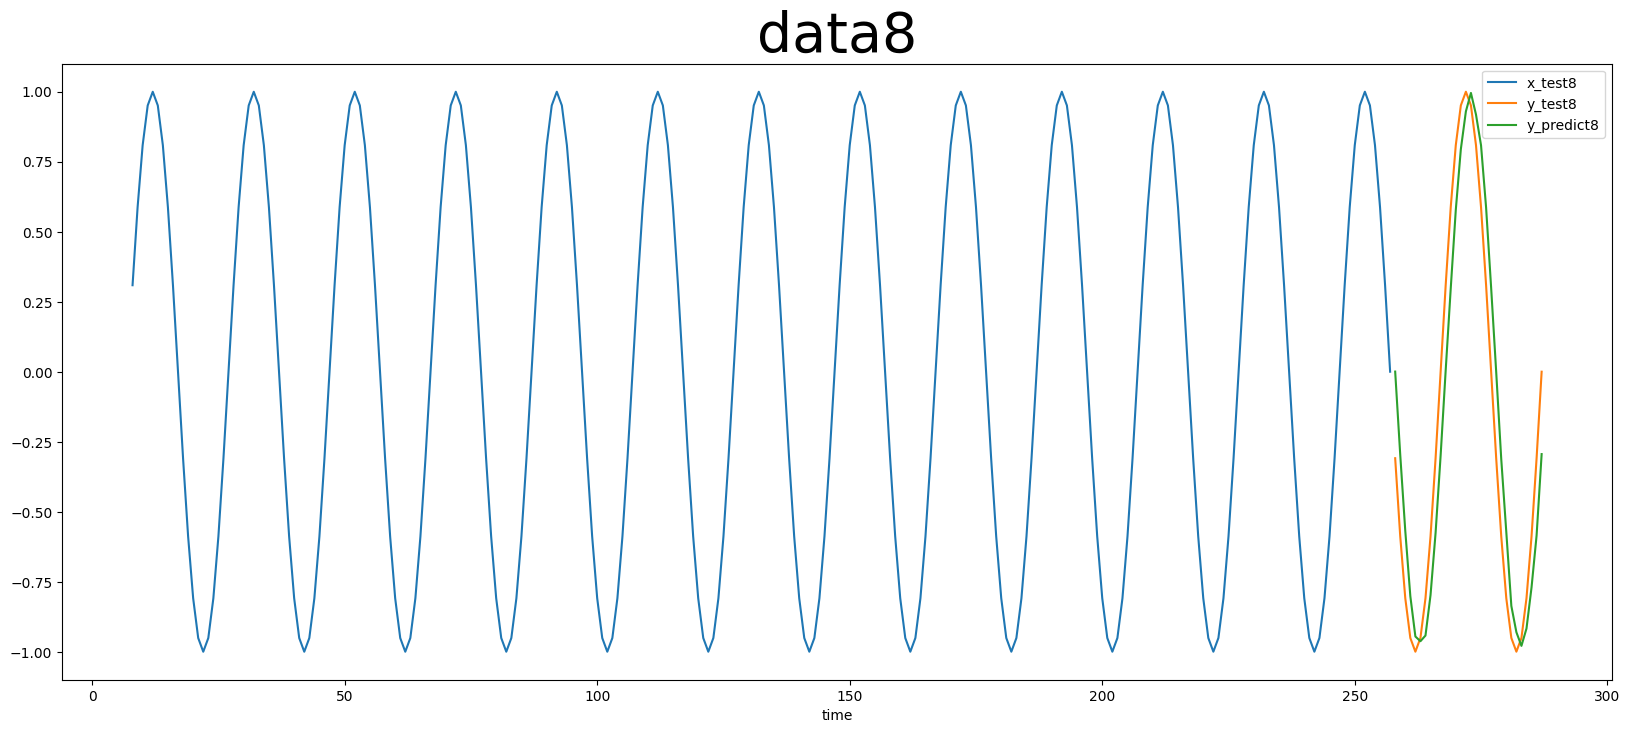

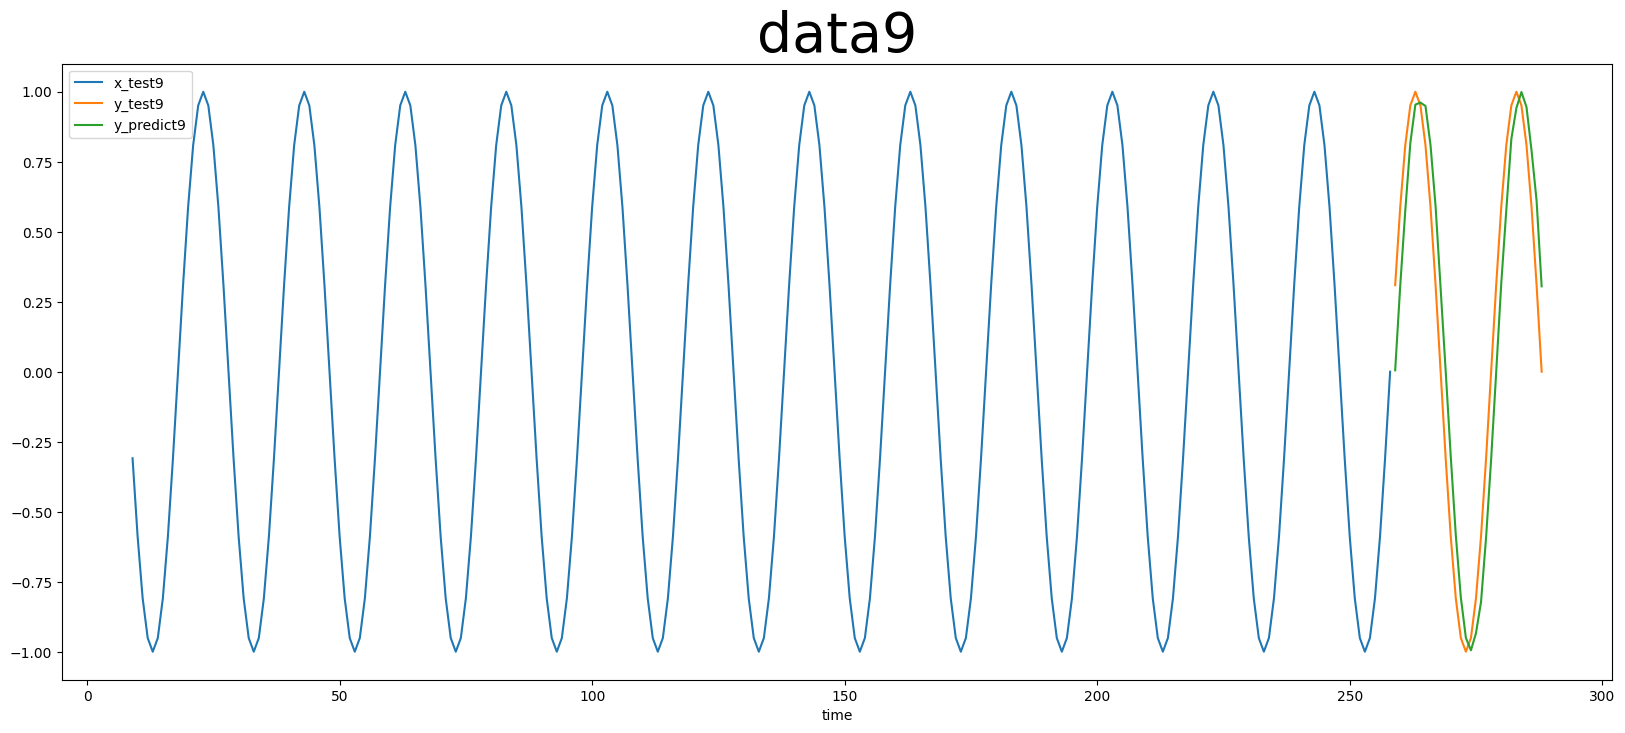

In [ ]:
for num in range(0, 10, 1):
    plt.figure(figsize=(20, 8))
    for i in range(num, num+1):
        start = i
        singal = x_test[start]
        plt.plot(range(start,len(singal)+start), singal, label=f"x_test{i}")
    for i in range(num, num+1):
        start = i
        singal = y_test[start]
        plt.plot(range(start+len(x_test[start]),len(singal)+len(x_test[start])+start), singal, label=f"y_test{i}")
    for i in range(num, num+1):
        start = i
        singal = predicted_prices[start]
        plt.plot(range(start+len(x_test[start]),len(singal)+len(x_test[start])+start), singal, label=f"y_predict{i}")
    plt.xlabel("time")
    plt.title(f"data{i}", fontsize=40)
    plt.legend()
    plt.show()

In [ ]:
def find_data_pv_CL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    price = data['Close']
    data['peaks'] = pd.Series(dtype='float64')
    data['valleys'] = pd.Series(dtype='float64')
    data['pv'] = pd.Series(dtype='str')
    for idx in range(0, len(price)):
        if idx < pv_range:
            if price[idx] == price.iloc[0:pv_range*2+1].max():
                data['peaks'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[0:pv_range*2+1].min():
                data['valleys'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'valley'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
            data['peaks'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'peak'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
            data['valleys'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'valley'


In [ ]:
predicted_prices.shape[1]

30

In [ ]:
def find_signal_pv_function(signal_souce, pv_range, test_data, slide):
    pd.options.mode.chained_assignment = None
    signal = {}
    for i in range(0, predicted_prices.shape[0]):
        data = pd.Series(signal_souce[i])
        signal[i] = pd.DataFrame()
        signal[i]['Close'] = data
        signal[i].index = test_data.index[range(i*slide, i*slide+predicted_prices.shape[1])]
        signal[i]['peaks'] = pd.Series(dtype='float64')
        signal[i]['valleys'] = pd.Series(dtype='float64')
        signal[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(data)):
            if idx < pv_range:
                if data[idx] == data.iloc[0:pv_range*2+1].max():
                    signal[i]['peaks'].iloc[idx] = data[idx]
                    signal[i]['pv'].iloc[idx] = 'peak'
                if data[idx] == data.iloc[0:pv_range*2+1].min():
                    signal[i]['valleys'].iloc[idx] = data[idx]
                    signal[i]['pv'].iloc[idx] = 'valley'
            if data[idx] == data.iloc[idx-pv_range:idx+pv_range].max():
                signal[i]['peaks'].iloc[idx] = data[idx]
                signal[i]['pv'].iloc[idx] = 'peak'
            if data[idx] == data.iloc[idx-pv_range:idx+pv_range].min():
                signal[i]['valleys'].iloc[idx] = data[idx]
                signal[i]['pv'].iloc[idx] = 'valley'
    return signal


In [ ]:
pv_range = 2
test_data['Close'] = actual_prices
find_data_pv_CL_function(test_data, pv_range)
processed_signal = find_signal_pv_function(predicted_prices, pv_range, test_data, slide)

C:\Users\e4903\AppData\Local\Temp\ipykernel_14980\849117802.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Close'] = actual_prices


In [ ]:
def find_signal_lead_train_function(data, processed_signal):
    for p in processed_signal:
        data = test_data.loc[processed_signal[p].index[0]:processed_signal[p].index[-1]]
        processing_signal = processed_signal[p]
        p_data = pd.DataFrame(
            {'peaks': data['peaks'], 'count': range(len(data))})
        p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
        p_data_count = list(p_data['count'])
        p_signal = pd.DataFrame(
            {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
        p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
        p_signal_list = list(p_signal['count'])
        p_lead = []
        for i in range(0, len(p_signal_list)):
            temp = []
            temp_abs = []
            temp_2 = []
            for j in range(0, len(p_data_count)):
                temp.append((p_data_count[j] - p_signal_list[i]))
                temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
            for k in range(0, len(temp_abs)):
                if temp_abs[k] == min(temp_abs):
                    temp_2 = temp[k]
            p_lead.append(temp_2)
        p_signal['lead'] = p_lead

        v_data = pd.DataFrame(
            {'valleys': data['valleys'], 'count': range(len(data))})
        v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
        v_data_count = list(v_data['count'])
        v_signal = pd.DataFrame(
            {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
        v_signal = v_signal.drop(
            v_signal[v_signal['valleys'].isna()].index)
        v_signal_list = list(v_signal['count'])
        v_lead = []
        for i in range(0, len(v_signal_list)):
            temp = []
            temp_abs = []
            temp_2 = []
            for j in range(0, len(v_data_count)):
                temp.append((v_data_count[j] - v_signal_list[i]))
                temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
            for k in range(0, len(temp_abs)):
                if temp_abs[k] == min(temp_abs):
                    temp_2 = temp[k]
            v_lead.append(temp_2)
        v_signal['lead'] = v_lead

        processed_signal[p]['lead'] = pd.Series(dtype='float64')
        processed_signal[p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
        processed_signal[p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']

In [ ]:
find_signal_lead_train_function(test_data, processed_signal)

In [ ]:
test_data

,Open,High,Low,Close,Adj Close,Volume,peaks,valleys,pv
Date,,,,,,,,,
2019-01-02,2476.959961,2519.489990,2467.469971,-0.305995,2510.030029,3733160000,-0.305995,NaN,peak
2019-01-03,2491.919922,2493.139893,2443.959961,-0.584763,2447.889893,3858830000,NaN,NaN,NaN
2019-01-04,2474.330078,2538.070068,2474.330078,-0.805994,2531.939941,4234140000,NaN,NaN,NaN
2019-01-07,2535.610107,2566.159912,2524.560059,-0.948033,2549.689941,4133120000,NaN,NaN,NaN
2019-01-08,2568.110107,2579.820068,2547.560059,-0.996976,2574.409912,4120060000,NaN,-0.996976,valley
...,...,...,...,...,...,...,...,...,...
2019-06-24,2951.419922,2954.919922,2944.050049,0.003093,2945.350098,3136960000,NaN,NaN,NaN
2019-06-25,2945.780029,2946.520020,2916.010010,-0.305923,2917.379883,3579430000,NaN,NaN,NaN
2019-06-26,2926.070068,2932.590088,2912.989990,-0.584691,2913.780029,3511350000,NaN,NaN,NaN


In [ ]:
processed_signal

{0:                Close     peaks   valleys      pv  lead
 Date                                                  
 2019-01-02  0.000552  0.000552       NaN    peak   0.0
 2019-01-03 -0.296432       NaN       NaN     NaN   NaN
 2019-01-04 -0.568392       NaN       NaN     NaN   NaN
 2019-01-07 -0.801515       NaN       NaN     NaN   NaN
 2019-01-08 -0.945564       NaN       NaN     NaN   NaN
 2019-01-09 -0.962475       NaN -0.962475  valley  -1.0
 2019-01-10 -0.942148       NaN       NaN     NaN   NaN
 2019-01-11 -0.797625       NaN       NaN     NaN   NaN
 2019-01-14 -0.575645       NaN       NaN     NaN   NaN
 2019-01-15 -0.298956       NaN       NaN     NaN   NaN
 2019-01-16  0.005048       NaN       NaN     NaN   NaN
 2019-01-17  0.297324       NaN       NaN     NaN   NaN
 2019-01-18  0.577537       NaN       NaN     NaN   NaN
 2019-01-22  0.794430       NaN       NaN     NaN   NaN
 2019-01-23  0.929761       NaN       NaN     NaN   NaN
 2019-01-24  0.995618  0.995618       NaN    

In [ ]:
def get_first_lead_function(processed_signal):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        temp = processed_signal[i].loc[list(
            processed_signal[i]['lead'].dropna().index)[0]]
        first_date[i] = list(processed_signal[i]
                             ['lead'].dropna().index)[0]
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [ ]:
first_date, lead, pv = get_first_lead_function(processed_signal)

In [ ]:
def built_result_table_function(processed_signal, lead, pv):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv'])
    for i in processed_signal:
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
        result_table.loc[i, 's_date'] = processed_signal[i].index[0]
    return result_table


In [ ]:
result_table = built_result_table_function(processed_signal, lead, pv)
print(result_table)

                s_date t_date  lead ans_date      pv
0  2019-01-02 00:00:00    NaN   0.0      NaN    peak
1  2019-01-16 00:00:00    NaN  14.0      NaN  valley
2  2019-01-31 00:00:00    NaN  14.0      NaN    peak
3  2019-02-14 00:00:00    NaN  14.0      NaN  valley
4  2019-03-01 00:00:00    NaN  14.0      NaN    peak
5  2019-03-15 00:00:00    NaN  14.0      NaN  valley
6  2019-03-29 00:00:00    NaN  14.0      NaN    peak
7  2019-04-12 00:00:00    NaN  14.0      NaN  valley
8  2019-04-29 00:00:00    NaN  14.0      NaN    peak
9  2019-05-13 00:00:00    NaN  14.0      NaN  valley


In [ ]:
def result_table_process_function(result_table, data, first_date):
    for i in result_table.index:
        t_date = first_date[i]
        result_table.loc[i, 't_date'] = t_date
        ans = data.iloc[int(data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [ ]:
result_table_process_function(result_table, test_data, first_date)

In [ ]:
def compute_final_error_function(result_table):
    final_error = round(
        sum([abs(ele) for ele in result_table['lead']]) / len(result_table['lead']), 2)
    return final_error


In [ ]:
final_error = compute_final_error_function(result_table)

In [ ]:
def evaluate_model(processed_signal, test_data, first_date, lead, pv):
    result_table = built_result_table_function(processed_signal, lead, pv)
    result_table_process_function(result_table, test_data, first_date)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error

In [ ]:
result_table, final_error = evaluate_model(processed_signal, test_data, first_date, lead, pv)

In [ ]:
print(result_table)

                s_date               t_date  lead             ans_date      pv
0  2019-01-02 00:00:00  2019-01-02 00:00:00   0.0  2019-01-02 00:00:00    peak
1  2019-01-16 00:00:00  2019-01-16 00:00:00  14.0  2019-02-06 00:00:00  valley
2  2019-01-31 00:00:00  2019-01-31 00:00:00  14.0  2019-02-21 00:00:00    peak
3  2019-02-14 00:00:00  2019-02-14 00:00:00  14.0  2019-03-07 00:00:00  valley
4  2019-03-01 00:00:00  2019-03-01 00:00:00  14.0  2019-03-21 00:00:00    peak
5  2019-03-15 00:00:00  2019-03-15 00:00:00  14.0  2019-04-04 00:00:00  valley
6  2019-03-29 00:00:00  2019-03-29 00:00:00  14.0  2019-04-18 00:00:00    peak
7  2019-04-12 00:00:00  2019-04-12 00:00:00  14.0  2019-05-03 00:00:00  valley
8  2019-04-29 00:00:00  2019-04-29 00:00:00  14.0  2019-05-17 00:00:00    peak
9  2019-05-13 00:00:00  2019-05-13 00:00:00  14.0  2019-06-03 00:00:00  valley


In [ ]:
print(f'final_error = {final_error}')

final_error = 12.6


In [ ]:
def draw_plot_result_table(test_data, all_data, result_table, pv_range):
    date_list = sorted(
        list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
    all_index = all_data.loc[date_list[0]:date_list[-1]].index
    fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
    test_data= test_data.drop(test_data[test_data.index > date_list[-1]].index)
    axes[0].plot(test_data.index, test_data['Close'], 'gray', label='data', linewidth=3)
    axes[0].plot(test_data.index, test_data['peaks'],
                '^', c='royalblue', label='peaks')
    axes[0].plot(test_data.index, test_data['valleys'], 'v',
                c='orangered', label='valleys')
    plot_model = pd.DataFrame(index=all_index, columns=[
                                's_date', 't_date', 'ans_date', 'lead', 'pv'])
    plot_model['s_date'].loc[result_table['s_date']] = True
    plot_model['t_date'].loc[result_table['t_date']] = True
    plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
    plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
    plot_model['ans_date'].loc[result_table['ans_date']] = True
    for i, label in enumerate(plot_model['lead']):
        if plot_model['pv'][i] == 'peak':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
                            c='royalblue')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)
        elif plot_model['pv'][i] == 'valley':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
                            c='orangered')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)

    axes[0].set_ylabel("Stock price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("lead", fontsize=14)
    plt.show()

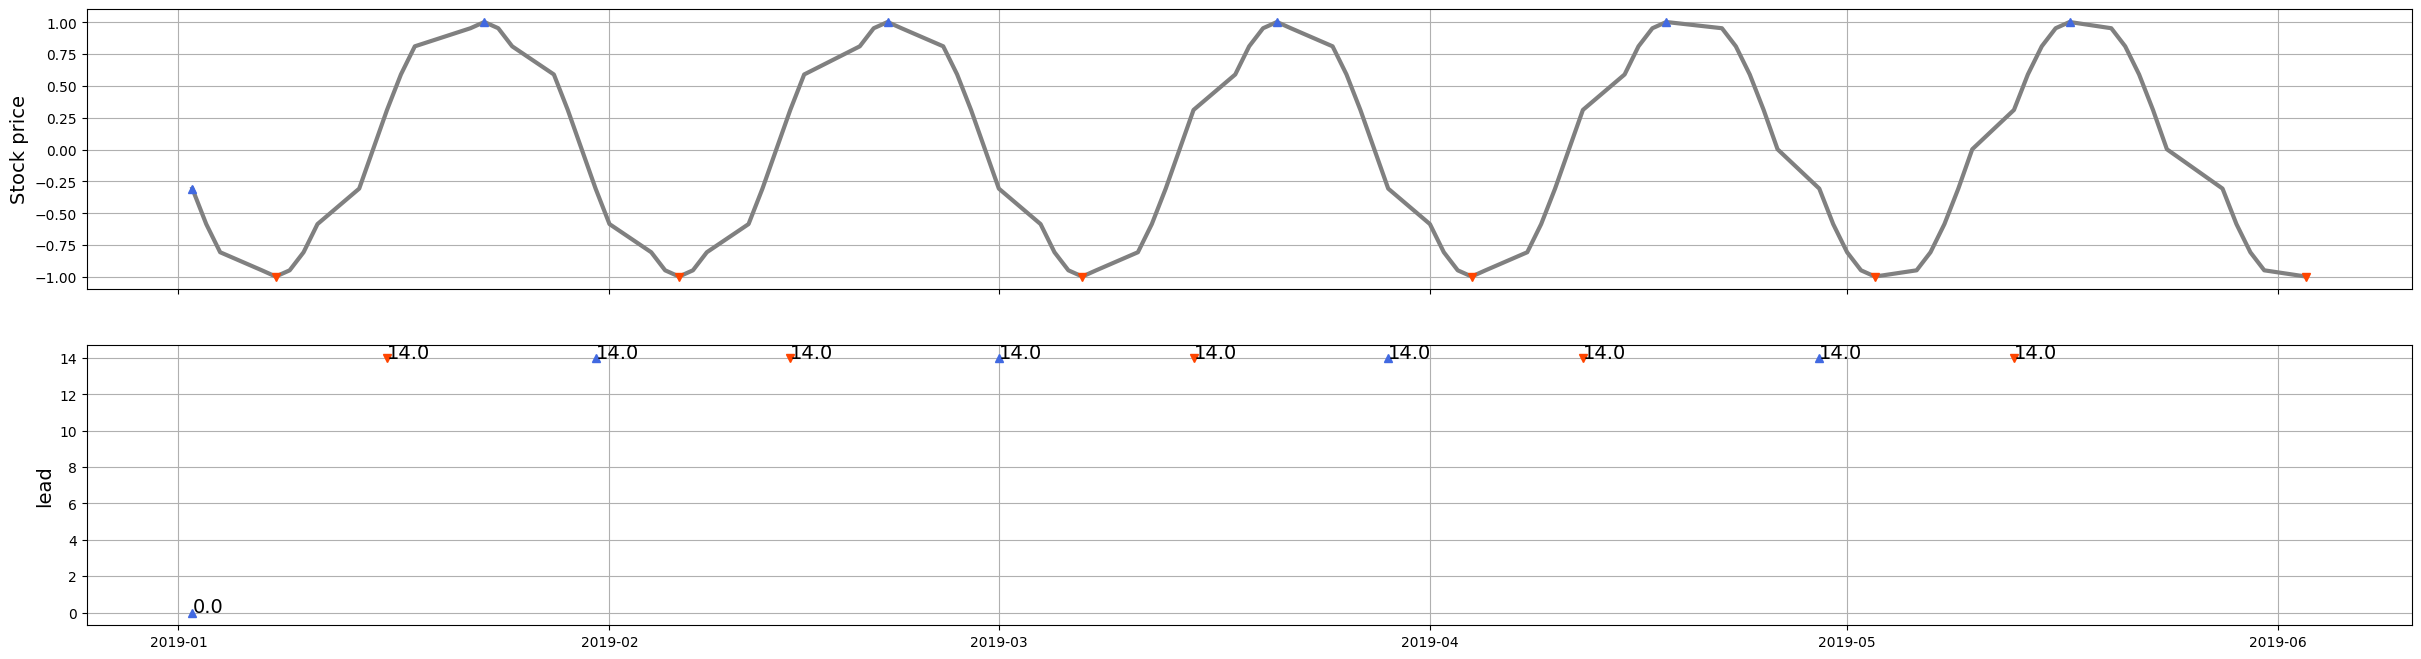

In [ ]:
draw_plot_result_table(test_data, data, result_table, pv_range)